##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [42]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from ipywidgets import FloatProgress
from IPython.display import display
import os
# pool.close()

In [43]:
def TTV_Split(iteration,Memory,X,y,params,X_fill):
    if params['Save']['Model']==True:
        params['Save']['Weights'] = True
    params['seed'] = int(iteration%params['splits_per_mod']/params['splits_per_mod']*100)
    params['iteration'] = int(iteration/params['splits_per_mod'])
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=params['seed'])
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=params['seed'])
    return(Dense.Train_Steps(params,X_train,X_test,X_val,y_train,y_test,
        y_val,X_fill = X_fill,Memory=Memory),
        y_val,params)

def RunReps(Model,params,Runs):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    Yval = []
    y_val= []
    for i in range(params['K']):
        results = TTV_Split(i,Memory,X,y,params,X_fill)
        Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
        y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
        Runs['MSE'].iloc[i] = metrics.mean_squared_error(y_val,Yval)
        Runs['R2'].iloc[i] = metrics.r2_score(y_val,Yval)
        params=results[2]
        Runs['iteration'].iloc[i] = params['iteration']
        Runs['seed'].iloc[i] = params['seed']
    return(Runs)

In [44]:
FillVar = 'fch4'

# cwd = os.getcwd()
# print(cwd)
os.chdir('C:/Users/wesle/NetworkAnalysis/')
Model = ['PPFD_Avg','Sedge']
N = 34

Path = 'Data_Footprints_2018-06-12.csv'
Runs,params = Dense.Params('Test',FillVar,MP=False)
Runs['iteration'] = 0
Runs['seed'] = 0

params['N'] = N
params['Save']['Model'] = True
params['Model'] = 'Kitty'#'+'.join(Model)
print(params)
Runs = Runs.iloc[0:params['K']].drop('Model',axis=1)
Runs['N'] = params['N']
Runs = RunReps(Model,params,Runs)


{'proc': 1, 'K': 4, 'epochs': 100, 'Y': 'fch4', 'splits_per_mod': 2, 'Save': {'Weights': False, 'Model': True}, 'N': 34, 'Model': 'Kitty'}
Saved model to disk


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [45]:
# print(Runs.groupby('Iteration').mean())

Loaded model from disk
(870, 2)
(870, 2)


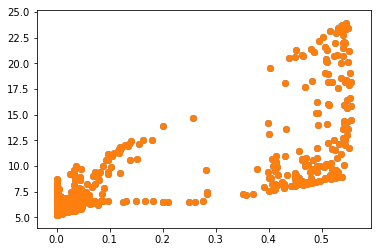

In [46]:
from keras.models import model_from_json

import ReadStandardTimeFill as RSTF
json_file = open('C:/Users/wesle/NetworkAnalysis/'+FillVar+'/Weights/'+params['Model']+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
# Min = 
loaded_model.load_weights('C:/Users/wesle/NetworkAnalysis/'+FillVar+'/Weights/'+params['Model']+'_0_0.h5')
print("Loaded model from disk")


# plt.figure(figsize=(10,10))
# FullModel = fco2_summary.loc[fco2_summary['Level']==0,'Model'].values[0].split('+')

for i in range(2):
    RST = RSTF.ReadStandardTimeFill('Data_Footprints_2018-06-12.csv')
    RST.Scale('fch4',Model)
    y = RST.y*1.0
    X = RST.X*1.0
    print(X.shape)
#     if i == 0:
#         X[:,0]=X[:,0].min()
#     if i == 1:
#         X[:,0]=X[:,0].mean()
#     if i == 2:
#         X[:,0]=X[:,0].max()
    loaded_model.compile(loss='mean_squared_error', optimizer='adam')#loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#     score = loaded_model.evaluate(X, y, verbose=1)
    rest = loaded_model.predict(X)
    rest = RST.YScaled.inverse_transform(rest.reshape(-1,1))
    X = RST.XScaled.inverse_transform(X)
#     print(score)
    plt.scatter(X[:,1],rest,label=X[:,0].mean())
# plt.legend()

In [39]:
Time = time.time()
# def RunLoop(Runs):
    
#     f = FloatProgress(min=0, max=Runs['N'].count()) # instantiate the bar
#     display(f) # display the bar
# #     print(Runs)
#     for N in Runs['N'].unique():   
#         f.value+=params['K']
#         params['T'] = 0
#         params['N']=N
#         Results = RunReps(FullModel,params,pool)
#         MSE = Results[0]
#         R2 = Results[1]
#         Runs.loc[Runs['N']==N,'MSE']=MSE
#         Runs.loc[Runs['N']==N,'R2']=R2
# #         print(Runs.loc[Runs['N']==N])
#     return(Runs)

A Jupyter Widget